# SC1015 Assignment

## Table of Contents
---
1. Importing the Data
    - Why we are only using 2018 and 2019 data
    - Importing the actual data 
2. Data Cleaning
    - Date and Time
3. EDA
---
## Problem Statement
How do we predict a flight delay

### Motivation
Returning from covid

### Dataset
The dataset includes 2018 to 2020
However, only 2018 and 2019 is used as explained more in-depth
---
## Import Libraries


In [1]:
#imports
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

pd.set_option("display.max_columns", 500)
plt.style.use('ggplot')

## Importing the data

In [2]:
# Mount from google colab
# from google.colab import drive
# drive.mount('/content/drive')
# root = "/content/drive/MyDrive/Datasets/SC1015/"

# Personal laptops
root = "../data/"

### Importing the data to be used

In [3]:
# Import the data that will actually be used
column_subset = ['FlightDate',
                 'Airline',
                 'Operating_Airline',
                 'Origin',
                 'Dest',
                 'Cancelled',
                 'Diverted',
                 'CRSDepTime',
                 'DepTime',
                 'ArrDelayMinutes', 
                 'DepDelayMinutes', 
                 'OriginAirportID',
                 'OriginStateName',
                 'DestAirportID',
                 'DestCityName',
                 'DestStateName',
                 'ArrTime', 'CRSArrTime'
                 #'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'
                ]

years = [2018, 2019]
dataframes = []

for year in years:
    df = pd.read_parquet(f"{root}Combined_Flights_{year}.parquet", columns=column_subset)
    dataframes.append(df)
del df

flights_df = pd.concat(dataframes).reset_index(drop=True)

In [4]:
print(flights_df.shape)

(13781196, 18)


In [5]:
print(flights_df.columns)

Index(['FlightDate', 'Airline', 'Operating_Airline', 'Origin', 'Dest',
       'Cancelled', 'Diverted', 'CRSDepTime', 'DepTime', 'ArrDelayMinutes',
       'DepDelayMinutes', 'OriginAirportID', 'OriginStateName',
       'DestAirportID', 'DestCityName', 'DestStateName', 'ArrTime',
       'CRSArrTime'],
      dtype='object')


In [6]:
# Airports
airports_df = pd.read_csv(f"{root}airlines.csv")

## Data Cleaning

### Categorising appropriate columns

In [7]:
flights_df.columns

Index(['FlightDate', 'Airline', 'Operating_Airline', 'Origin', 'Dest',
       'Cancelled', 'Diverted', 'CRSDepTime', 'DepTime', 'ArrDelayMinutes',
       'DepDelayMinutes', 'OriginAirportID', 'OriginStateName',
       'DestAirportID', 'DestCityName', 'DestStateName', 'ArrTime',
       'CRSArrTime'],
      dtype='object')

In [8]:
flights_df.describe() 

,FlightDate,CRSDepTime,DepTime,ArrDelayMinutes,DepDelayMinutes,OriginAirportID,DestAirportID,ArrTime,CRSArrTime
count,13781196,1.378120e+07,1.354792e+07,1.350388e+07,1.354670e+07,1.378120e+07,1.378120e+07,1.353366e+07,1.378120e+07
mean,2019-02-11 19:11:11.206413568,1.330309e+03,1.334702e+03,1.411466e+01,1.394830e+01,1.269441e+04,1.269436e+04,1.462606e+03,1.483724e+03
min,2018-01-01 00:00:00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.013500e+04,1.013500e+04,1.000000e+00,1.000000e+00
25%,2018-09-17 00:00:00,9.150000e+02,9.160000e+02,0.000000e+00,0.000000e+00,1.129200e+04,1.129200e+04,1.047000e+03,1.100000e+03
50%,2019-02-28 00:00:00,1.323000e+03,1.327000e+03,0.000000e+00,0.000000e+00,1.288900e+04,1.288900e+04,1.502000e+03,1.512000e+03
75%,2019-07-30 00:00:00,1.735000e+03,1.745000e+03,8.000000e+00,7.000000e+00,1.405700e+04,1.405700e+04,1.915000e+03,1.918000e+03
max,2019-12-31 00:00:00,2.359000e+03,2.400000e+03,2.973000e+03,2.976000e+03,1.686900e+04,1.686900e+04,2.400000e+03,2.400000e+03
std,NaN,4.909026e+02,5.047816e+02,4.665277e+01,4.687052e+01,1.516753e+03,1.516743e+03,5.396836e+02,5.193956e+02


In [9]:
flights_df.dtypes

FlightDate           datetime64[ns]
Airline                      object
Operating_Airline            object
Origin                       object
Dest                         object
Cancelled                      bool
Diverted                       bool
CRSDepTime                    int64
DepTime                     float64
ArrDelayMinutes             float64
DepDelayMinutes             float64
OriginAirportID               int64
OriginStateName              object
DestAirportID                 int64
DestCityName                 object
DestStateName                object
ArrTime                     float64
CRSArrTime                    int64
dtype: object

In [10]:
cat_cols = ["Airline", "Operating_Airline" , "Origin", "Dest", "OriginStateName", "DestStateName"]
for c in cat_cols:
    flights_df[c] = flights_df[c].astype("category")

adding a new column to categorise flights as either delayed, cancelled or on time.  
we have defined them as follows:  
Cancelled: if the Cancelled column value == 1  
Delayed: if the ArrDelayMinutes column value is > 0  
we have assumed a flight to be delayed if the arrival time is after the estimated arrival time

In [11]:
flights_df['DelaySituation'] = 'OnTime'
flights_df.loc[flights_df['Cancelled'], 'DelaySituation'] = 'Cancelled'
flights_df.loc[(flights_df['ArrDelayMinutes'] > 0) & (~flights_df['Cancelled']), 'DelaySituation'] = 'Delayed'
display(flights_df)

,FlightDate,Airline,Operating_Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,ArrDelayMinutes,DepDelayMinutes,OriginAirportID,OriginStateName,DestAirportID,DestCityName,DestStateName,ArrTime,CRSArrTime,DelaySituation
0,2018-01-23,Endeavor Air Inc.,9E,ABY,ATL,False,False,1202,1157.0,0.0,0.0,10146,Georgia,10397,"Atlanta, GA",Georgia,1256.0,1304,OnTime
1,2018-01-24,Endeavor Air Inc.,9E,ABY,ATL,False,False,1202,1157.0,0.0,0.0,10146,Georgia,10397,"Atlanta, GA",Georgia,1258.0,1304,OnTime
2,2018-01-25,Endeavor Air Inc.,9E,ABY,ATL,False,False,1202,1153.0,0.0,0.0,10146,Georgia,10397,"Atlanta, GA",Georgia,1302.0,1304,OnTime
3,2018-01-26,Endeavor Air Inc.,9E,ABY,ATL,False,False,1202,1150.0,0.0,0.0,10146,Georgia,10397,"Atlanta, GA",Georgia,1253.0,1304,OnTime
4,2018-01-27,Endeavor Air Inc.,9E,ABY,ATL,False,False,1400,1355.0,0.0,0.0,10146,Georgia,10397,"Atlanta, GA",Georgia,1459.0,1500,OnTime
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13781191,2019-01-23,ExpressJet Airlines Inc.,EV,MEM,IAH,False,False,640,634.0,13.0,0.0,13244,Tennessee,12266,"Houston, TX",Texas,853.0,840,Delayed
13781192,2019-01-24,ExpressJet Airlines Inc.,EV,MEM,IAH,False,False,640,631.0,0.0,0.0,13244,Tennessee,12266,"Houston, TX",Texas,830.0,840,OnTime
13781193,2019-01-25,ExpressJet Airlines Inc.,EV,MEM,IAH,False,False,640,632.0,0.0,0.0,13244,Tennessee,12266,"Houston, TX",Texas,828.0,840,OnTime
13781194,2019-01-26,ExpressJet Airlines Inc.,EV,MEM,IAH,False,False,640,630.0,0.0,0.0,13244,Tennessee,12266,"Houston, TX",Texas,831.0,840,OnTime


### Creating a new column to get the expected Departure and Arrival times

In [12]:
time_cols = ["ArrTime", "DepTime", "CRSArrTime", "CRSDepTime"]
for col in time_cols:
    flights_df[col] = flights_df[col].fillna(0)
    flights_df[col] = pd.to_numeric(flights_df[col], errors='coerce')
    flights_df[col] = flights_df[col].astype(int)
    flights_df[col] = flights_df[col].astype(str)

In [13]:
def combine_date_time(date_col, time_col, new_col_name):
    date_str = flights_df[date_col].astype(str)
    time_str = flights_df[time_col].astype(str)
    time_str = time_str.apply(lambda x: x.zfill(4) if len(x) < 4 else x.rjust(4, '0'))
    datetime_str = date_str + ' ' + time_str
    
    flights_df[new_col_name] = pd.to_datetime(datetime_str, format='%Y-%m-%d %H%M')


In [14]:
#flights_df.loc[:5, ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]]

In [15]:
combine_date_time("FlightDate", "CRSDepTime", "CRSDepFlightDate")

In [16]:
flights_df.loc[:10, ["CRSDepFlightDate", "CRSDepTime", "DepTime", "DepDelayMinutes", "CRSArrTime", "ArrTime", "ArrDelayMinutes"]]

,CRSDepFlightDate,CRSDepTime,DepTime,DepDelayMinutes,CRSArrTime,ArrTime,ArrDelayMinutes
0,2018-01-23 12:02:00,1202,1157,0.0,1304,1256,0.0
1,2018-01-24 12:02:00,1202,1157,0.0,1304,1258,0.0
2,2018-01-25 12:02:00,1202,1153,0.0,1304,1302,0.0
3,2018-01-26 12:02:00,1202,1150,0.0,1304,1253,0.0
4,2018-01-27 14:00:00,1400,1355,0.0,1500,1459,0.0
5,2018-01-28 12:02:00,1202,1202,NaN,1304,1326,22.0
6,2018-01-29 12:02:00,1202,1204,2.0,1304,1303,0.0
7,2018-01-30 12:02:00,1202,1153,0.0,1304,1255,0.0
8,2018-01-31 12:02:00,1202,1153,0.0,1304,1304,NaN
9,2018-01-03 10:37:00,1037,1101,24.0,1137,1159,22.0


### Checking how complete the dataset is


In [17]:
missing_df = flights_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(flights_df.shape[0]-missing_df['missing values'])/flights_df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ArrDelayMinutes,277313,97.987744
1,DepDelayMinutes,234493,98.298457
2,CRSArrTime,0,100.000000
3,ArrTime,0,100.000000
4,DestStateName,0,100.000000
5,DestCityName,0,100.000000
6,DestAirportID,0,100.000000
7,OriginStateName,0,100.000000
8,OriginAirportID,0,100.000000
9,FlightDate,0,100.000000


## EDA

### Which airline has the most delays

In [18]:
flights_df['Airline'].value_counts()

Airline
Southwest Airlines Co.                       2716498
Delta Air Lines Inc.                         1453704
SkyWest Airlines Inc.                        1368547
American Airlines Inc.                       1331959
United Air Lines Inc.                        1247475
JetBlue Airways                               602421
Republic Airlines                             533125
Envoy Air                                     454834
Alaska Airlines Inc.                          449568
Comair Inc.                                   406121
Mesa Airlines Inc.                            381528
Spirit Air Lines                              381023
Endeavor Air Inc.                             377276
ExpressJet Airlines Inc.                      301457
Frontier Airlines Inc.                        255578
Horizon Air                                   207142
Air Wisconsin Airlines Corp                   205657
Allegiant Air                                 201526
Hawaiian Airlines Inc.                

Creating a dataframe of the airlines and sorting the number of delayed, ontime and cancelled flights.  
then dividing those numbers by number of total flights per airline and multplying by 100 so as to get percentages

In [22]:
flights_df['Airline'] = flights_df['Airline'].astype('category')
airline_df = flights_df.groupby('Airline')['DelaySituation'].value_counts().unstack()
display(airline_df)

total_flights = airline_df.sum(axis=1)
print(type(total_flights))
for value in airline_df.columns:
    airline_df[value] = (airline_df[value] / total_flights)*100

total_flights = total_flights.sort_values(ascending=False).index
display(airline_df)


DelaySituation,Cancelled,Delayed,OnTime
Airline,,,
Air Wisconsin Airlines Corp,6725,63924,135008
Alaska Airlines Inc.,4681,156109,288778
Allegiant Air,1393,76705,123428
American Airlines Inc.,25582,498298,808079
Cape Air,2,435,1224
Capital Cargo International,7172,55279,105043
Comair Inc.,10091,142457,253573
"Commutair Aka Champlain Enterprises, Inc.",5475,47807,52780
Compass Airlines,793,46870,91444


<class 'pandas.core.series.Series'>


DelaySituation,Cancelled,Delayed,OnTime
Airline,,,
Air Wisconsin Airlines Corp,3.270008,31.082822,65.647170
Alaska Airlines Inc.,1.041222,34.724224,64.234554
Allegiant Air,0.691226,38.062086,61.246688
American Airlines Inc.,1.920630,37.410911,60.668459
Cape Air,0.120409,26.189043,73.690548
Capital Cargo International,4.281944,33.003570,62.714485
Comair Inc.,2.484727,35.077477,62.437796
"Commutair Aka Champlain Enterprises, Inc.",5.162075,45.074579,49.763346
Compass Airlines,0.570065,33.693488,65.736447


In [21]:
airline_df.loc[total_flights].sort_values('OnTime', ascending=False) \
    [['OnTime','Delayed','Cancelled']] \
    .style.background_gradient(axis=0,cmap='YlOrRd')

DelaySituation,OnTime,Delayed,Cancelled
Airline,,,
Cape Air,73.690548,26.189043,0.120409
Delta Air Lines Inc.,71.868620,27.856703,0.274678
Endeavor Air Inc.,70.240355,28.047371,1.712274
Spirit Air Lines,66.377620,32.224301,1.398078
Hawaiian Airlines Inc.,66.332765,33.436348,0.230888
"GoJet Airlines, LLC d/b/a United Express",66.257953,32.084511,1.657536
Compass Airlines,65.736447,33.693488,0.570065
Air Wisconsin Airlines Corp,65.647170,31.082822,3.270008
SkyWest Airlines Inc.,65.457525,32.708705,1.833770


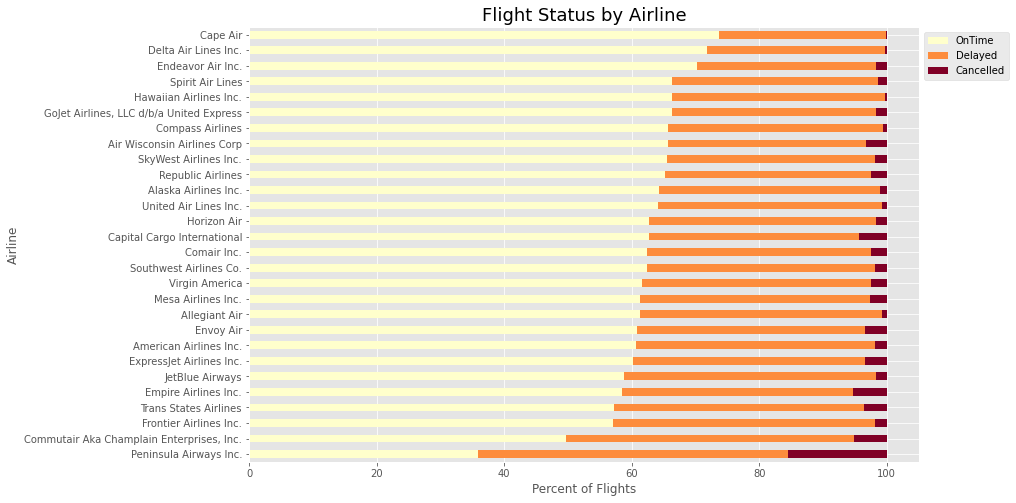

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
airline_df.sort_values('OnTime')[['OnTime','Delayed','Cancelled']].plot(kind='barh', stacked=True, ax=ax, cmap='YlOrRd')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Flight Status by Airline', fontsize=18)
ax.set_xlabel('Percent of Flights')
plt.show()

Plotting airline vs number of flights 

### Taking a look at the delay time distributions

Based on: https://en.wikipedia.org/wiki/Flight_cancellation_and_delay
Flight delays can be categorised into 3 different categories.

We'll start by plotting for the frequency of delays of those 60 minutes or under.

In [ ]:
flights_df.query('DepDelayMinutes > 0 & DepDelayMinutes <= 60')['DepDelayMinutes'].plot(kind='hist', bins=30)